In [21]:
import tensorflow as tf
from keras import layers, models, regularizers
from keras.datasets import cifar10
from keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
#from keras.callbacks import LearningRateScheduler
from keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import optuna
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle



In [22]:
# Load and preprocess the dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0  # Normalize data
train_labels, test_labels = to_categorical(train_labels), to_categorical(test_labels)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(train_images)

In [23]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def create_simple_cnn():
    model = models.Sequential()
    
    # First convolutional block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Second convolutional block
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Third convolutional block
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))  # 10 units for 10 classes in CIFAR-10
    
    # Compile the model
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Example usage:
model = create_simple_cnn()


In [24]:

plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
# Training the model
batch_size = 64  # feel free to change it according to your system configuration
epochs = 10  # for better performance increase the number of epochs
history = model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                    steps_per_epoch=train_images.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(test_images, test_labels),
                    verbose=2)

Epoch 1/10
781/781 - 48s - loss: 1.6869 - accuracy: 0.3788 - val_loss: 1.3647 - val_accuracy: 0.5060 - 48s/epoch - 61ms/step
Epoch 2/10
781/781 - 44s - loss: 1.3737 - accuracy: 0.5060 - val_loss: 1.1879 - val_accuracy: 0.5765 - 44s/epoch - 56ms/step
Epoch 3/10
781/781 - 42s - loss: 1.2368 - accuracy: 0.5601 - val_loss: 1.1710 - val_accuracy: 0.5929 - 42s/epoch - 54ms/step
Epoch 4/10
781/781 - 44s - loss: 1.1569 - accuracy: 0.5928 - val_loss: 1.0237 - val_accuracy: 0.6416 - 44s/epoch - 56ms/step
Epoch 5/10
781/781 - 43s - loss: 1.1014 - accuracy: 0.6131 - val_loss: 0.9801 - val_accuracy: 0.6610 - 43s/epoch - 56ms/step
Epoch 6/10
781/781 - 61s - loss: 1.0526 - accuracy: 0.6326 - val_loss: 0.9642 - val_accuracy: 0.6660 - 61s/epoch - 79ms/step
Epoch 7/10
781/781 - 93s - loss: 1.0172 - accuracy: 0.6440 - val_loss: 1.0298 - val_accuracy: 0.6533 - 93s/epoch - 119ms/step
Epoch 8/10
781/781 - 95s - loss: 0.9829 - accuracy: 0.6559 - val_loss: 0.9141 - val_accuracy: 0.6831 - 95s/epoch - 122ms/ste

In [26]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 3s - loss: 0.8457 - accuracy: 0.7112 - 3s/epoch - 9ms/step

Test accuracy: 0.7111999988555908


313/313 [==============================] - 5s 15ms/step


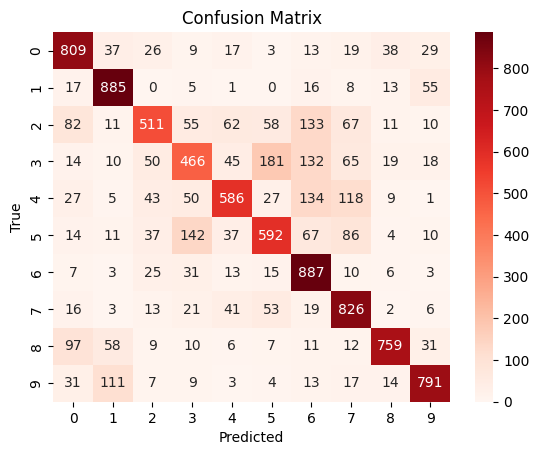

              precision    recall  f1-score   support

      Class1       0.73      0.81      0.77      1000
      Class2       0.78      0.89      0.83      1000
      Class3       0.71      0.51      0.59      1000
      Class4       0.58      0.47      0.52      1000
      Class5       0.72      0.59      0.65      1000
      Class6       0.63      0.59      0.61      1000
      Class7       0.62      0.89      0.73      1000
      Class8       0.67      0.83      0.74      1000
      Class9       0.87      0.76      0.81      1000
     Class10       0.83      0.79      0.81      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000



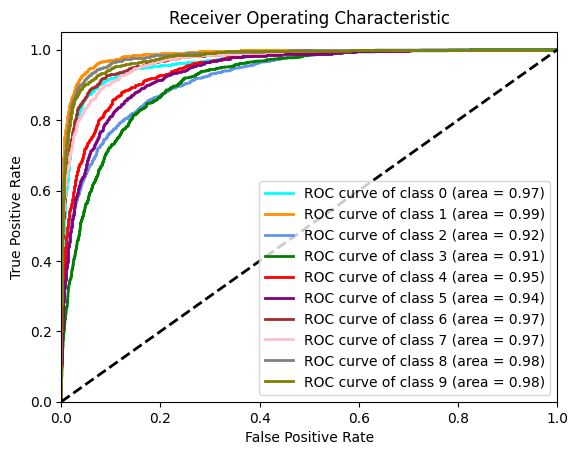

In [27]:
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

#confusion matrix
conf_mtx = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(conf_mtx, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

class_names = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9', 'Class10']
print(classification_report(true_classes, predicted_classes, target_names=class_names))

#ROC-AUC

# Binarize the labels
bin_true_classes = label_binarize(true_classes, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = bin_true_classes.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(bin_true_classes[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [29]:
def compile_and_train_model(model, num_epochs, batch_size, x_train, y_train, x_val, y_val):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_val, y_val))
    return history

def objective(trial, x_test, y_test, x_train, y_train, x_val, y_val):
    # Suggested hyperparameters
    #dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
    num_epochs = trial.suggest_int('num_epochs', 5, 50)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    
    
    # Create model with suggested hyperparameters
    model = create_simple_cnn()
    
    history = compile_and_train_model(model, num_epochs, batch_size, x_train, y_train, x_val, y_val)
    
    # Evaluating the model
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)
    return 1.0 - accuracy  # aim to maximize accuracy

# Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, train_images, train_labels, test_images, test_labels, test_images, test_labels), n_trials=5)

# Print the result
best_params = study.best_params
best_score = study.best_value
print(f"The best parameters are {best_params} with a score of {best_score}")

[I 2023-10-14 17:57:54,486] A new study created in memory with name: no-name-0bb54f94-5271-45db-9263-56e6d8d76daa
C:\Users\S_CSIS-PostGrad\AppData\Local\Temp\ipykernel_19900\1870971454.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)


Epoch 1/32
625/625 [==============================] - 25s 32ms/step - loss: 1.8842 - accuracy: 0.2925 - val_loss: 1.5574 - val_accuracy: 0.4344
Epoch 2/32
625/625 [==============================] - 21s 33ms/step - loss: 1.5016 - accuracy: 0.4551 - val_loss: 1.3361 - val_accuracy: 0.5273
Epoch 3/32
625/625 [==============================] - 20s 32ms/step - loss: 1.3209 - accuracy: 0.5245 - val_loss: 1.1922 - val_accuracy: 0.5700
Epoch 4/32
625/625 [==============================] - 19s 30ms/step - loss: 1.1934 - accuracy: 0.5686 - val_loss: 1.1023 - val_accuracy: 0.6151
Epoch 5/32
625/625 [==============================] - 19s 31ms/step - loss: 1.0786 - accuracy: 0.6177 - val_loss: 0.9202 - val_accuracy: 0.6776
Epoch 6/32
625/625 [==============================] - 20s 31ms/step - loss: 0.9871 - accuracy: 0.6507 - val_loss: 0.8383 - val_accuracy: 0.7086
Epoch 7/32
625/625 [==============================] - 20s 32ms/step - loss: 0.9074 - accuracy: 0.6786 - val_loss: 0.7417 - val_accuracy:

[I 2023-10-14 18:15:06,092] Trial 0 finished with value: 0.42510002851486206 and parameters: {'weight_decay': 3.194205981472156e-05, 'num_epochs': 32, 'batch_size': 16}. Best is trial 0 with value: 0.42510002851486206.


Epoch 1/18
157/157 [==============================] - 44s 174ms/step - loss: 1.9935 - accuracy: 0.2556 - val_loss: 1.7541 - val_accuracy: 0.3441
Epoch 2/18
157/157 [==============================] - 21s 137ms/step - loss: 1.6594 - accuracy: 0.3891 - val_loss: 1.5473 - val_accuracy: 0.4371
Epoch 3/18
157/157 [==============================] - 22s 138ms/step - loss: 1.5015 - accuracy: 0.4488 - val_loss: 1.4136 - val_accuracy: 0.4873
Epoch 4/18
157/157 [==============================] - 22s 138ms/step - loss: 1.3885 - accuracy: 0.4933 - val_loss: 1.3333 - val_accuracy: 0.5203
Epoch 5/18
157/157 [==============================] - 21s 136ms/step - loss: 1.3096 - accuracy: 0.5247 - val_loss: 1.2435 - val_accuracy: 0.5582
Epoch 6/18
157/157 [==============================] - 21s 136ms/step - loss: 1.2268 - accuracy: 0.5608 - val_loss: 1.1638 - val_accuracy: 0.5836
Epoch 7/18
157/157 [==============================] - 22s 138ms/step - loss: 1.1528 - accuracy: 0.5955 - val_loss: 1.1018 - val_ac

[I 2023-10-14 18:23:04,152] Trial 1 finished with value: 0.42309999465942383 and parameters: {'weight_decay': 0.0002610864290708791, 'num_epochs': 18, 'batch_size': 64}. Best is trial 0 with value: 0.42510002851486206.


Epoch 1/20
157/157 [==============================] - 45s 172ms/step - loss: 2.0011 - accuracy: 0.2546 - val_loss: 1.7862 - val_accuracy: 0.3365
Epoch 2/20
157/157 [==============================] - 21s 137ms/step - loss: 1.6705 - accuracy: 0.3877 - val_loss: 1.5378 - val_accuracy: 0.4429
Epoch 3/20
157/157 [==============================] - 21s 134ms/step - loss: 1.5043 - accuracy: 0.4554 - val_loss: 1.3819 - val_accuracy: 0.5068
Epoch 4/20
157/157 [==============================] - 21s 135ms/step - loss: 1.3785 - accuracy: 0.5026 - val_loss: 1.3012 - val_accuracy: 0.5257
Epoch 5/20
157/157 [==============================] - 23s 146ms/step - loss: 1.3030 - accuracy: 0.5293 - val_loss: 1.2182 - val_accuracy: 0.5630
Epoch 6/20
157/157 [==============================] - 25s 158ms/step - loss: 1.2240 - accuracy: 0.5600 - val_loss: 1.1602 - val_accuracy: 0.5890
Epoch 7/20
157/157 [==============================] - 23s 145ms/step - loss: 1.1586 - accuracy: 0.5876 - val_loss: 1.0949 - val_ac

[I 2023-10-14 18:32:01,459] Trial 2 finished with value: 0.4024999737739563 and parameters: {'weight_decay': 5.3960468074798795e-05, 'num_epochs': 20, 'batch_size': 64}. Best is trial 0 with value: 0.42510002851486206.


Epoch 1/38
79/79 [==============================] - 42s 285ms/step - loss: 2.1269 - accuracy: 0.2104 - val_loss: 1.9203 - val_accuracy: 0.3018
Epoch 2/38
79/79 [==============================] - 18s 232ms/step - loss: 1.7674 - accuracy: 0.3524 - val_loss: 1.7355 - val_accuracy: 0.3716
Epoch 3/38
79/79 [==============================] - 18s 233ms/step - loss: 1.6011 - accuracy: 0.4183 - val_loss: 1.4906 - val_accuracy: 0.4609
Epoch 4/38
79/79 [==============================] - 18s 230ms/step - loss: 1.4873 - accuracy: 0.4595 - val_loss: 1.4525 - val_accuracy: 0.4733
Epoch 5/38
79/79 [==============================] - 17s 217ms/step - loss: 1.4128 - accuracy: 0.4934 - val_loss: 1.4390 - val_accuracy: 0.4732
Epoch 6/38
79/79 [==============================] - 18s 228ms/step - loss: 1.3693 - accuracy: 0.5069 - val_loss: 1.3718 - val_accuracy: 0.4949
Epoch 7/38
79/79 [==============================] - 17s 219ms/step - loss: 1.2931 - accuracy: 0.5380 - val_loss: 1.2570 - val_accuracy: 0.5493

[I 2023-10-14 18:44:32,923] Trial 3 finished with value: 0.4136999845504761 and parameters: {'weight_decay': 0.034331598131814536, 'num_epochs': 38, 'batch_size': 128}. Best is trial 0 with value: 0.42510002851486206.


Epoch 1/13
79/79 [==============================] - 39s 268ms/step - loss: 2.0978 - accuracy: 0.2220 - val_loss: 1.9224 - val_accuracy: 0.2976
Epoch 2/13
79/79 [==============================] - 18s 232ms/step - loss: 1.8025 - accuracy: 0.3399 - val_loss: 1.7528 - val_accuracy: 0.3681
Epoch 3/13
79/79 [==============================] - 18s 234ms/step - loss: 1.6640 - accuracy: 0.3959 - val_loss: 1.6373 - val_accuracy: 0.4190
Epoch 4/13
79/79 [==============================] - 17s 219ms/step - loss: 1.5453 - accuracy: 0.4330 - val_loss: 1.5087 - val_accuracy: 0.4398
Epoch 5/13
79/79 [==============================] - 17s 214ms/step - loss: 1.4641 - accuracy: 0.4649 - val_loss: 1.4556 - val_accuracy: 0.4727
Epoch 6/13
79/79 [==============================] - 17s 213ms/step - loss: 1.3883 - accuracy: 0.4985 - val_loss: 1.3245 - val_accuracy: 0.5203
Epoch 7/13
79/79 [==============================] - 17s 218ms/step - loss: 1.3259 - accuracy: 0.5203 - val_loss: 1.3282 - val_accuracy: 0.5302

[I 2023-10-14 18:49:49,335] Trial 4 finished with value: 0.450219988822937 and parameters: {'weight_decay': 5.963084475650284e-05, 'num_epochs': 13, 'batch_size': 128}. Best is trial 4 with value: 0.450219988822937.


The best parameters are {'weight_decay': 5.963084475650284e-05, 'num_epochs': 13, 'batch_size': 128} with a score of 0.450219988822937
